In [100]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
import yfinance as yfin
import scipy
import MH4518.WY.Utils.constants as cs
import MH4518.WY.Utils.Dates as dates 
import MH4518.WY.Utils.payoff as pf
import MH4518.WY.Utils.GBM as gbm
import MH4518.WY.Utils.ProductPrice as pp 

import warnings
warnings.filterwarnings("ignore")
import multiprocessing as mp
import pandas as pd
import logging


In [101]:
def getdata():
    data = yfin.download(['LONN.SW', 'SIKA.SW'], period= 'max')['Adj Close']
    data.index = data.index.tz_localize(None)
    data = data.loc[cs.initial_fixing_date: cs.final_fixing_date]
    return data 

data = getdata()

[*********************100%***********************]  2 of 2 completed


In [102]:
def read_hist_rates():
    swiss_1_week = pd.read_csv(r'C:\Users\Admin\PycharmProjects\Simulation Techniques in Finance\.venv\MH4518\WY\Data\Switzerland 1-Week Bond Yield Historical Data.csv', index_col = 0, parse_dates=True, infer_datetime_format=True)
    swiss_1_month = pd.read_csv(r'C:\Users\Admin\PycharmProjects\Simulation Techniques in Finance\.venv\MH4518\WY\Data\Switzerland 1-Month Bond Yield Historical Data.csv', index_col = 0 , parse_dates=True, infer_datetime_format=True)
    swiss_2_month = pd.read_csv(r'C:\Users\Admin\PycharmProjects\Simulation Techniques in Finance\.venv\MH4518\WY\Data\Switzerland 2-Month Bond Yield Historical Data.csv', index_col = 0 , parse_dates=True, infer_datetime_format=True)
    swiss_6_month = pd.read_csv(r'C:\Users\Admin\PycharmProjects\Simulation Techniques in Finance\.venv\MH4518\WY\Data\Switzerland 6-Month Bond Yield Historical Data.csv', index_col = 0 , parse_dates=True, infer_datetime_format=True)
    swiss_1_year = pd.read_csv(r'C:\Users\Admin\PycharmProjects\Simulation Techniques in Finance\.venv\MH4518\WY\Data\Switzerland 1-Year Bond Yield Historical Data.csv' , index_col = 0 , parse_dates=True, infer_datetime_format=True)
    combined = pd.concat([swiss_1_week[["Price"]], swiss_1_month[["Price"]], swiss_2_month[["Price"]], swiss_6_month[["Price"]], swiss_1_year[["Price"]]], axis = 1)
    combined.columns = ["1 week Price", "1 month Price", "2 month Price", "6 month Price", "1 Year Price"]
   
    return combined

df = read_hist_rates()
df


,1 week Price,1 month Price,2 month Price,6 month Price,1 Year Price
Date,,,,,
2022-04-01,-0.77,-0.80,-0.71,-0.70,-0.57
2022-04-02,-0.77,-0.90,-0.74,-0.70,NaN
2022-04-03,-1.00,-0.80,-0.80,-0.70,-0.57
2022-04-04,-0.89,-0.90,-0.71,-0.70,-0.55
2022-04-05,-0.95,-0.90,-0.71,-0.70,-0.55
...,...,...,...,...,...
2024-10-28,0.77,0.69,0.60,0.51,0.56
2024-10-29,0.85,0.77,0.80,0.51,0.61
2024-10-30,0.77,0.68,0.80,0.51,0.62


In [103]:
maturity_to_years = {
    '1 week Price': 1/52,
    '1 month Price': 1/12,
    '2 month Price': 2/12,
    '6 month Price': 6/12,
    '1 Year Price': 1
}
maturities = df.columns.tolist()
times_to_maturity = np.array([maturity_to_years[m] for m in maturities])

In [104]:
for col in df.columns:
    df[col] = df[col].apply(lambda x: np.exp(-x/100*maturity_to_years[col]))
df

,1 week Price,1 month Price,2 month Price,6 month Price,1 Year Price
Date,,,,,
2022-04-01,1.000148,1.000667,1.001184,1.003506,1.005716
2022-04-02,1.000148,1.000750,1.001234,1.003506,NaN
2022-04-03,1.000192,1.000667,1.001334,1.003506,1.005716
2022-04-04,1.000171,1.000750,1.001184,1.003506,1.005515
2022-04-05,1.000183,1.000750,1.001184,1.003506,1.005515
...,...,...,...,...,...
2024-10-28,0.999852,0.999425,0.999000,0.997453,0.994416
2024-10-29,0.999837,0.999359,0.998668,0.997453,0.993919
2024-10-30,0.999852,0.999433,0.998668,0.997453,0.993819


In [105]:
def vasicek_bond_price(a, b, sigma, r0, T):
    B = (1 - np.exp(-a * T)) / a
    A = (b - (sigma**2) / (2 * a**2)) * (B - T) - (sigma**2) * B**2 / (4 * a)
    P = np.exp(A - B * r0)
    return P

In [106]:
from scipy.optimize import minimize
def calibration_objective(params, bond_maturities, bond_prices, r0):
    a, b, sigma = params
    # Ensure sigma is positive
    if sigma < 0:
        return np.inf
    model_prices = vasicek_bond_price(a, b, sigma, r0, bond_maturities)
    error = bond_prices - model_prices
    return np.sum(error**2)

# ---------------------------
# 3. Calibration Function
# ---------------------------

def calibrate_vasicek(bond_maturities, bond_prices, r0):
    initial_guess = [0.1, 0.05, 0.01]  # [a, b, sigma]
    bounds = [
        (0.01, 1.0),   # a
        (0.01, 0.15),  # b
        (0.001, 0.1)    # sigma
    ]
    
    result = minimize(
        calibration_objective,
        initial_guess,
        args=(bond_maturities, bond_prices, r0),
        method='L-BFGS-B',
        bounds=bounds,
        options={'disp': True}
    )
    
    if result.success:
        calibrated_a, calibrated_b, calibrated_sigma = result.x
        calibrated_params = {
            'a': calibrated_a,
            'b': calibrated_b,
            'sigma': calibrated_sigma
        }
        print(f"Calibration successful: {calibrated_params}")
        return calibrated_params
    else:
        raise ValueError("Calibration failed: " + result.message)

In [107]:
calibrated_params = calibrate_vasicek(times_to_maturity, df.loc[cs.initial_fixing_date], 0.015)

Calibration successful: {'a': np.float64(0.10826990922393587), 'b': np.float64(0.06695567691237256), 'sigma': np.float64(0.008832060537589417)}


In [108]:
def simulate_vasicek(a, b, sigma, r0, T, dt, N_simulations):
    """
    Simulate paths for the stochastic Vasicek interest rate model.
    
    Parameters:
    - a: Speed of mean reversion
    - b: Long-term mean level
    - sigma: Volatility of the interest rate
    - r0: Initial interest rate
    - T: Time horizon (years)
    - dt: Time step size
    - N_simulations: Number of simulation paths
    
    Returns:
    - time_grid: Array of time points
    - r_paths: Simulated interest rate paths (N_simulations x N_steps)
    """
    N_steps = int(T / dt)
    time_grid = np.linspace(0, T, N_steps + 1)
    r_paths = np.zeros((N_simulations, N_steps + 1))
    r_paths[:, 0] = r0
    
    dates = pd.date_range(cs.initial_fixing_date, cs.final_fixing_date)
    for t in range(1, N_steps + 1):
        dr = a * (b - r_paths[:, t-1]) * dt + sigma * np.sqrt(dt) * np.random.randn(N_simulations)
        r_paths[:, t] = r_paths[:, t-1] + dr
    
    return time_grid, r_paths



In [109]:
a_calibrated = calibrated_params['a']
b_calibrated = calibrated_params['b']
sigma_r_calibrated = calibrated_params['sigma']

time_grid, r_paths = simulate_vasicek(a_calibrated, b_calibrated, sigma_r_calibrated, 0.015, 1.25, 1/365, 100)

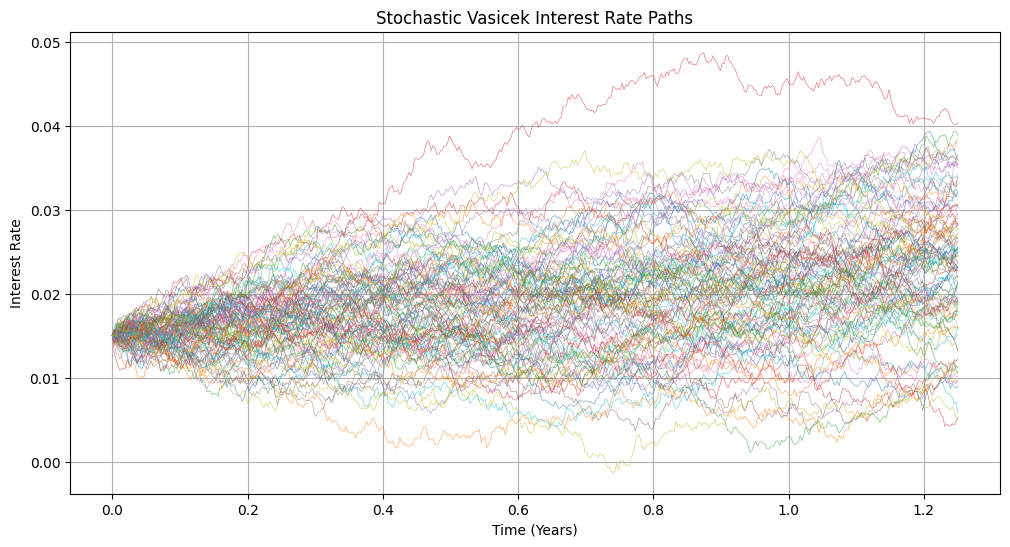

In [110]:
import matplotlib.pyplot as plt
import numpy as np

def plot_vasicek_matplotlib(time_grid, r_paths, num_paths=100):
    """
    Plot a subset of Vasicek interest rate paths using Matplotlib.
    
    Parameters:
    - time_grid: Array of time points
    - r_paths: Simulated interest rate paths (N_simulations x N_steps)
    - num_paths: Number of paths to plot
    """
    plt.figure(figsize=(12, 6))
    
    # Randomly select paths to plot
    selected_indices = np.random.choice(r_paths.shape[0], size=num_paths, replace=False)
    
    for idx in selected_indices:
        plt.plot(time_grid, r_paths[idx], lw=0.5, alpha=0.6)
    
    plt.title('Stochastic Vasicek Interest Rate Paths')
    plt.xlabel('Time (Years)')
    plt.ylabel('Interest Rate')
    plt.grid(True)
    plt.show()

# Usage
plot_vasicek_matplotlib(time_grid, r_paths, num_paths=100)



In [111]:
from datetime import datetime
from dateutil.relativedelta import relativedelta


initial_date = cs.initial_fixing_date

new_date = initial_date + relativedelta(years=1, months=3)
new_date




Timestamp('2024-07-27 00:00:00')

In [122]:
r_paths = pd.DataFrame(r_paths).T
dates_index= pd.date_range(cs.initial_fixing_date, new_date, inclusive='left')
r_paths.index = dates_index
r_paths

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2023-04-27,0.015000,0.015000,0.015000,0.015000,0.015000,0.015000,0.015000,0.015000,0.015000,0.015000,...,0.015000,0.015000,0.015000,0.015000,0.015000,0.015000,0.015000,0.015000,0.015000,0.015000
2023-04-28,0.014977,0.015145,0.015076,0.014606,0.015270,0.015176,0.015298,0.015105,0.014583,0.014736,...,0.014814,0.015519,0.014446,0.014356,0.015147,0.015730,0.014799,0.014721,0.014220,0.014806
2023-04-29,0.015310,0.014905,0.014620,0.014906,0.015261,0.015984,0.014942,0.015317,0.014663,0.014869,...,0.014997,0.015736,0.014138,0.014700,0.015299,0.015642,0.014799,0.014327,0.014276,0.013959
2023-04-30,0.015365,0.015361,0.014290,0.015152,0.014989,0.016143,0.015006,0.014643,0.014616,0.014688,...,0.014355,0.015409,0.013983,0.014839,0.014823,0.015673,0.014400,0.014203,0.014678,0.013960
2023-05-01,0.015555,0.015287,0.014537,0.015404,0.014470,0.016641,0.016138,0.014516,0.014998,0.015262,...,0.014346,0.014820,0.014249,0.015420,0.013983,0.016442,0.013681,0.014189,0.014699,0.013920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-22,0.022678,0.018760,0.014950,0.024077,0.030084,0.026218,0.020387,0.033288,0.007882,0.032656,...,0.025148,0.019915,0.009860,0.019329,0.034062,0.015778,0.015152,0.019380,0.022257,0.026853
2024-07-23,0.022609,0.019431,0.014788,0.024171,0.030216,0.025890,0.020543,0.033882,0.007659,0.032214,...,0.025189,0.019901,0.009442,0.019655,0.033579,0.016074,0.014966,0.019568,0.021752,0.026097
2024-07-24,0.022226,0.018819,0.014705,0.024966,0.030514,0.024877,0.020611,0.035418,0.006864,0.032119,...,0.025047,0.019508,0.009578,0.019370,0.033916,0.016100,0.014404,0.020097,0.021453,0.025873
2024-07-25,0.021760,0.019432,0.015191,0.025339,0.030500,0.024452,0.020636,0.035175,0.007076,0.031476,...,0.025137,0.019725,0.009655,0.018340,0.033819,0.015962,0.014848,0.020407,0.020520,0.025960


In [123]:
def multi_asset_gbm(data: pd.DataFrame, fdos, nsims: int, r_paths) -> pd.DataFrame:
    """
    Simulates multiple asset paths under the risk-neutral measure using GBM for multiple simulations.
    """

    
    try:
        # Prepare the log returns DataFrame
        log_returns_df = pd.DataFrame()
        for ticker in cs.ticker_list:
            log_returns = np.log(data[ticker] / data[ticker].shift(1))
            log_returns_df[ticker] = log_returns
        log_returns_df.dropna(inplace=True)
        
        # Compute the covariance matrix of log returns
        cov_matrix = log_returns_df.cov().values
        vol_vector = np.sqrt(np.diag(cov_matrix))
        corr_matrix = cov_matrix / np.outer(vol_vector, vol_vector)
        L = np.linalg.cholesky(corr_matrix)
        
    except Exception as e:
        print("Error at covariance matrix computation:", e)
        raise
    
    try:
        # Simulation parameters
        date_list = dates.get_list_dates(fdos, cs.final_fixing_date)
        num_steps = len(date_list)  # Number of time steps
        dt = cs.dt  # Time step in years
        
        num_assets = cs.num_ticker  # Number of assets
        
        s0_vector = data.loc[fdos, cs.ticker_list].values  # Initial prices as NumPy array
        
        # Print lengths
        print(f"Length of date_list: {len(date_list)}")
        print(f"Number of time steps (num_steps): {num_steps}")
        
        # Precompute drift terms
        r = np.mean(r_paths.loc[fdos])
        drift = (r - 0.5 * vol_vector ** 2) * dt  # Shape: (num_assets,)
        
        # Generate random variables
        Z = np.random.normal(size=(num_steps - 1, nsims, num_assets))  # Shape: (num_steps-1, nsims, num_assets)
        Z_reshaped = Z.reshape(-1, num_assets)  # Shape: ((num_steps - 1) * nsims, num_assets)
        epsilon = Z_reshaped @ L.T  # Shape: ((num_steps - 1) * nsims, num_assets)
        epsilon = epsilon.reshape(num_steps - 1, nsims, num_assets)  # Shape: (num_steps - 1, nsims, num_assets)
        epsilon = epsilon * np.sqrt(dt)  # Scale by sqrt(dt)
        
        # Initialize array to hold simulated prices
        S = np.zeros((num_steps, nsims, num_assets))  # Shape: (num_steps, nsims, num_assets)
        S[0, :, :] = s0_vector  # Set initial prices for all simulations
        
        # Simulate asset prices
        for t in range(1, num_steps):
            S[t] = S[t - 1] * np.exp(
                drift + vol_vector * epsilon[t - 1]
            )
        
        # Transpose S to shape (num_steps, num_assets, nsims)
        S_transposed = S.transpose(0, 2, 1)  # Swap axes 1 and 2
        
        # Reshape S_transposed to (num_steps, num_assets * nsims)
        S_reshaped = S_transposed.reshape(num_steps, num_assets * nsims)
        
        # Build MultiIndex columns
        assets = cs.ticker_list
        simulations = [f'sim{n+1}' for n in range(nsims)]
        arrays = [[], []]
        for asset in assets:
            for sim in simulations:
                arrays[0].append(asset)
                arrays[1].append(sim)
        tuples = list(zip(*arrays))
        index = pd.MultiIndex.from_tuples(tuples, names=['Asset', 'Simulation'])
        
        # Create DataFrame
        sim_data = pd.DataFrame(S_reshaped, index=date_list)
        sim_data.columns = index
        
    except Exception as e:
        print("Error during simulation:", e)
        raise
        
    return sim_data

In [124]:
multi_asset_gbm(data = data, fdos = cs.initial_fixing_date, nsims=100, r_paths=r_paths)

Length of date_list: 315
Number of time steps (num_steps): 315


Asset          LONN.SW                                                  \
Simulation        sim1        sim2        sim3        sim4        sim5   
2023-04-27  542.120544  542.120544  542.120544  542.120544  542.120544   
2023-04-28  541.208396  541.376337  540.895730  542.060415  541.741997   
2023-05-02  541.437544  540.925120  540.849191  541.308715  540.898419   
2023-05-03  541.788769  540.317904  541.234887  540.056480  541.704900   
2023-05-04  542.149179  540.002815  541.679714  541.024921  543.069179   
...                ...         ...         ...         ...         ...   
2024-07-24  559.184464  542.748611  530.193898  551.428190  557.472027   
2024-07-25  560.235325  543.065437  529.999125  550.854313  557.269125   
2024-07-26  559.144198  543.066658  530.036319  550.321845  556.493266   
2024-07-29  558.942399  543.603334  529.516628  551.181672  556.561481   
2024-07-30  558.762913  543.563219  530.272596  550.775798  557.860345   

Asset                                                                   ...  \
Simulation        sim6        sim7        sim8        sim9       sim10  ...   
2023-04-27  542.120544  542.120544  542.120544  542.120544  542.120544  ...   
2023-04-28  542.275693  541.648402  542.898277  542.129664  541.909151  ...   
2023-05-02  542.876433  541.970077  542.310055  542.136525  542.675943  ...   
2023-05-03  542.704588  543.131147  541.529411  542.074145  542.397028  ...   
2023-05-04  543.157023  543.260287  541.090654  543.039973  543.113471  ...   
...                ...         ...         ...         ...         ...  ...   
2024-07-24  586.510377  560.024808  535.239541  540.936855  560.196153  ...   
2024-07-25  586.320696  559.197303  535.999813  540.537596  559.969770  ...   
2024-07-26  586.035794  558.503731  535.520656  540.305994  559.815347  ...   
2024-07-29  585.692017  557.659311  536.619555  540.187006  560.509603  ...   
2024-07-30  585.389543  558.239522  536.301971  539.299177  559.082271  ...   

Asset          SIKA.SW                                                  \
Simulation       sim91       sim92       sim93       sim94       sim95   
2023-04-27  237.429871  237.429871  237.429871  237.429871  237.429871   
2023-04-28  237.428321  237.496733  237.455452  237.366521  237.669686   
2023-05-02  237.652755  237.316091  237.661872  237.666907  237.778803   
2023-05-03  237.768663  237.410867  237.706794  237.752492  237.621225   
2023-05-04  238.030300  237.348007  237.712595  238.081525  237.589936   
...                ...         ...         ...         ...         ...   
2024-07-24  239.365437  243.695028  247.749444  243.295714  243.489898   
2024-07-25  239.618560  244.280239  247.581361  243.401871  243.519500   
2024-07-26  239.622848  244.294231  247.591425  243.549619  243.307756   
2024-07-29  239.564517  244.138530  247.840327  243.232308  243.139010   
2024-07-30  239.621590  244.143235  248.149850  242.984155  243.027210   

Asset                                                                   
Simulation       sim96       sim97       sim98       sim99      sim100  
2023-04-27  237.429871  237.429871  237.429871  237.429871  237.429871  
2023-04-28  237.378547  237.331134  237.418092  237.328513  237.339769  
2023-05-02  237.284188  237.333531  237.639561  237.355935  238.000476  
2023-05-03  237.299433  237.221232  238.028309  237.407963  238.451959  
2023-05-04  237.469737  237.633133  238.171869  237.488257  238.280402  
...                ...         ...         ...         ...         ...  
2024-07-24  246.497598  239.816985  245.060677  242.240814  240.532985  
2024-07-25  246.542442  239.870972  244.907848  242.006509  240.702089  
2024-07-26  246.086017  239.542616  244.680922  241.815707  240.462899  
2024-07-29  245.930753  239.545932  244.934734  241.496161  240.460794  
2024-07-30  245.651831  239.937895  244.983329  240.987103  240.818666  

[315 rows x 200 columns]

In [125]:
def multi_asset_gbm_n_sims(plot: bool, plotasset: bool, nsims: int, data: pd.DataFrame, fdos) -> pd.DataFrame:
    """
    Simulate multiple asset paths under the GBM model for 'nsims' simulations starting from 'fdos'.

    Params:
        plot (bool): Whether to plot the combined simulations.
        plotasset (bool): Whether to plot the simulations for each asset separately.
        nsims (int): Number of simulations to run.
        data (pd.DataFrame): Historical data for assets.
        fdos: First date of simulation.

    Returns:
        sim_data: DataFrame containing simulated asset prices for all simulations.
                  Columns are MultiIndex with levels ('Asset', 'Simulation')
    """

    # Get the list of dates for the simulation period
    date_list = dates.get_list_dates(fdos, cs.final_fixing_date)
    
    # Realized price from initial fixing date to final fixing date
    realised_price = data.loc[cs.initial_fixing_date: cs.final_fixing_date]
    
    try:
        # Run the simulation
        sim_data = multi_asset_gbm(data, fdos, nsims, r_paths)
        sim_data.index = date_list
        
    except Exception as e:
        raise Exception("Error during simulation") from e

    if plot:
        fig, ax = plt.subplots(figsize=(12, 6))
        # Plot the realized prices
        realised_price.plot(ax=ax, linewidth=2)
        # Plot the simulated paths
        for asset in cs.ticker_list:
            asset_columns = sim_data[asset]
            asset_columns.plot(ax=ax, alpha=0.4, legend=False)
        plt.title('Simulated Paths with Realized Prices')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.grid(True)
        plt.show()

    if plotasset:
        for asset in cs.ticker_list:
            # Select columns for the asset
            asset_columns = sim_data[asset]
            # Select the realized price for the asset
            realised_price_asset = realised_price[asset]  # Adjust the column name if necessary

            # Plot asset paths and realized price
            fig, ax = plt.subplots(figsize=(12, 6))
            asset_columns.plot(ax=ax, alpha=0.4, legend=False)
            realised_price_asset.plot(ax=ax, color='black', linewidth=2, label=f'Realized Price {asset}')
            ax.legend()
            plt.title(f'{asset} Paths under Multi Asset GBM')
            plt.xlabel('Date')
            plt.ylabel('Price')
            plt.grid(True)
            plt.show()
            
    return sim_data

Length of date_list: 315
Number of time steps (num_steps): 315


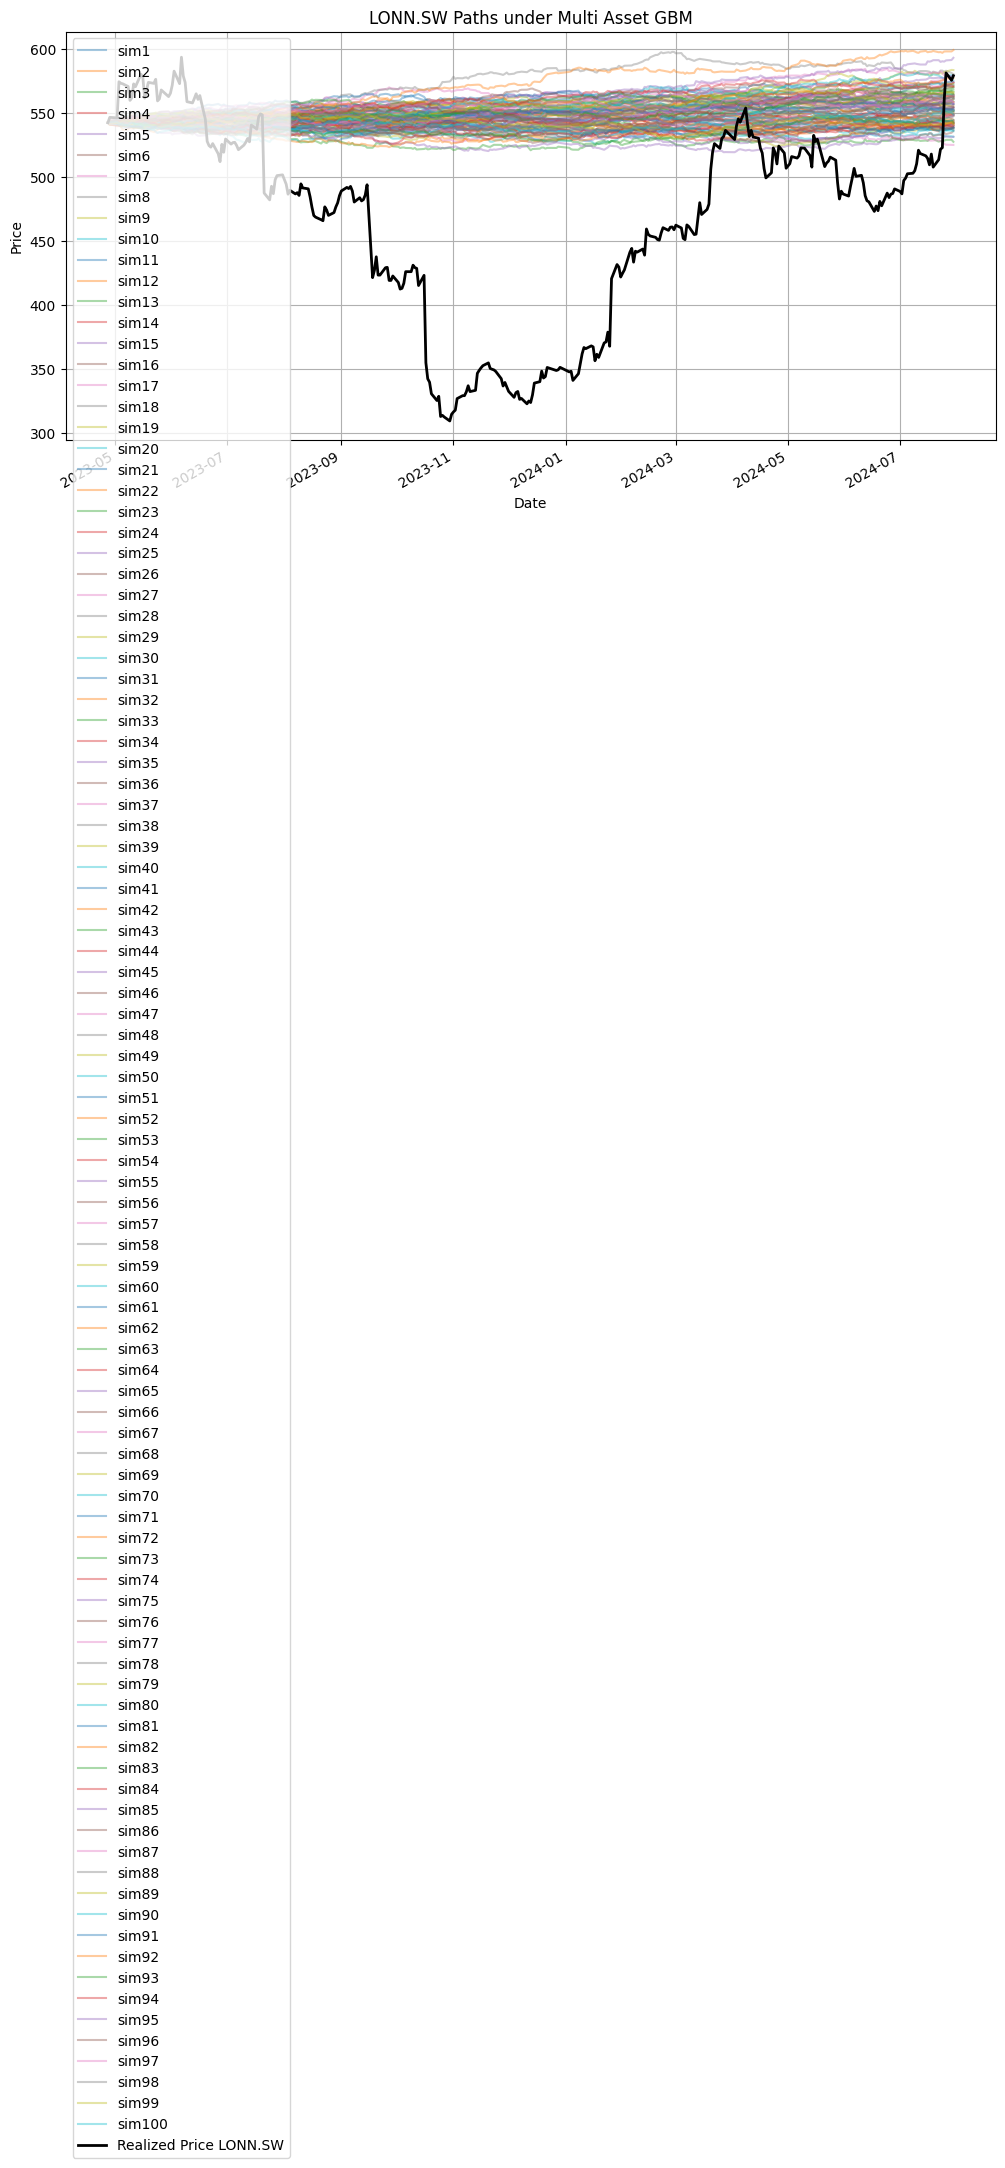

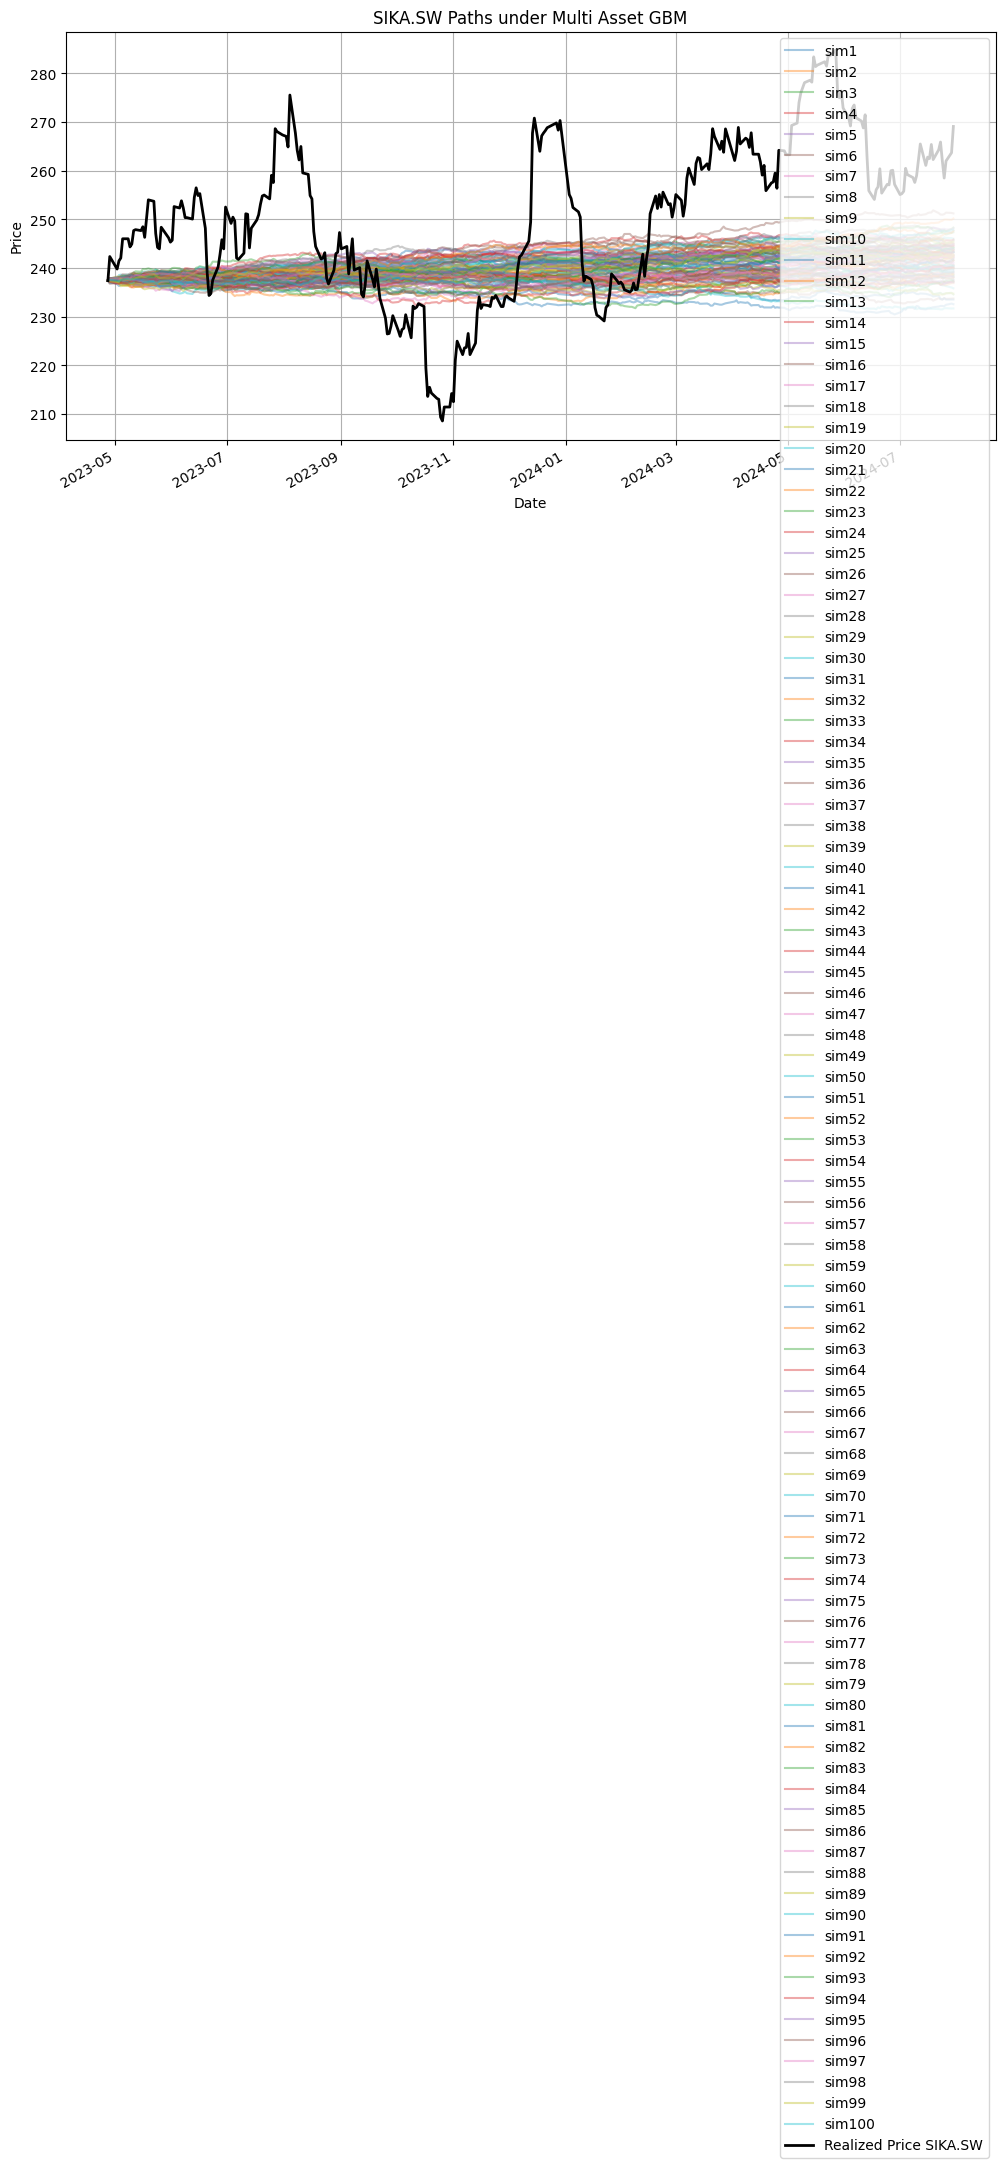

Asset          LONN.SW                                                  \
Simulation        sim1        sim2        sim3        sim4        sim5   
2023-04-27  542.120544  542.120544  542.120544  542.120544  542.120544   
2023-04-28  541.296142  541.453817  542.275823  541.983112  542.120464   
2023-05-02  543.659967  542.173869  542.313801  540.646894  543.039724   
2023-05-03  543.440881  542.768863  542.674122  541.303064  543.180702   
2023-05-04  541.772216  544.556154  542.051763  541.409601  543.150965   
...                ...         ...         ...         ...         ...   
2024-07-24  550.657204  545.295047  537.260499  538.279156  540.908432   
2024-07-25  551.022159  544.554043  536.761133  537.840690  539.976893   
2024-07-26  551.887284  543.972617  536.693547  538.407778  539.554914   
2024-07-29  552.087627  545.103951  537.541953  538.210374  539.160747   
2024-07-30  551.344383  544.401585  538.242507  540.091619  539.541616   

Asset                                                                   ...  \
Simulation        sim6        sim7        sim8        sim9       sim10  ...   
2023-04-27  542.120544  542.120544  542.120544  542.120544  542.120544  ...   
2023-04-28  541.571623  543.460759  542.296063  542.835907  543.005732  ...   
2023-05-02  541.925551  542.705732  542.063547  544.406877  543.983382  ...   
2023-05-03  540.944093  542.888402  542.287893  544.491061  544.899278  ...   
2023-05-04  541.175886  542.635392  542.545397  544.221165  545.459531  ...   
...                ...         ...         ...         ...         ...  ...   
2024-07-24  557.584744  563.186749  582.765110  580.373290  532.169697  ...   
2024-07-25  555.364900  563.062888  581.970973  581.596823  531.953572  ...   
2024-07-26  555.619795  562.434517  582.686990  581.966846  531.360105  ...   
2024-07-29  554.685844  563.565790  580.910094  583.321986  531.557386  ...   
2024-07-30  554.425631  563.797041  580.045198  583.212885  531.074782  ...   

Asset          SIKA.SW                                                  \
Simulation       sim91       sim92       sim93       sim94       sim95   
2023-04-27  237.429871  237.429871  237.429871  237.429871  237.429871   
2023-04-28  237.583511  237.762200  237.474427  237.185793  237.449851   
2023-05-02  237.753441  237.764695  237.358554  236.773888  237.486719   
2023-05-03  237.966416  238.072280  237.466581  236.732014  237.678019   
2023-05-04  238.071374  237.784212  237.356813  236.972202  237.626287   
...                ...         ...         ...         ...         ...   
2024-07-24  239.508541  249.715312  243.523741  243.149170  243.482199   
2024-07-25  239.498124  249.967457  243.943151  242.833814  243.464264   
2024-07-26  239.451752  249.981730  244.043638  242.993742  243.770774   
2024-07-29  239.652332  249.903326  243.743487  243.054255  243.939725   
2024-07-30  239.515305  250.187127  244.162417  243.573286  243.839854   

Asset                                                                   
Simulation       sim96       sim97       sim98       sim99      sim100  
2023-04-27  237.429871  237.429871  237.429871  237.429871  237.429871  
2023-04-28  237.697663  237.709786  237.700111  237.254481  237.632376  
2023-05-02  237.399720  237.916084  237.863755  237.118484  237.456818  
2023-05-03  237.455252  237.729085  238.151348  237.185803  237.259977  
2023-05-04  237.334527  237.950374  238.198088  237.857128  237.593234  
...                ...         ...         ...         ...         ...  
2024-07-24  241.379537  240.282935  243.749525  242.579709  231.512811  
2024-07-25  241.465373  240.349952  243.581116  242.412188  231.735565  
2024-07-26  241.545701  240.426153  243.662220  242.460312  231.762012  
2024-07-29  241.546281  240.852734  243.400048  242.159850  231.693335  
2024-07-30  241.587816  240.784566  243.297304  242.402959  231.707737  

[315 rows x 200 columns]

In [127]:
multi_asset_gbm_n_sims(plot=False, plotasset= True, nsims=100, data=data, fdos = cs.initial_fixing_date)